In [2]:
import pandas as pd
import numpy as np
import ROOT as R
#R.enableJSVis()
R.ROOT.EnableImplicitMT()

c1=R.TCanvas('c1','c1',900,700)

t=R.TLatex()
t.SetTextSize(0.04)

graphs={}

Welcome to JupyROOT 6.20/04


In [3]:
#few functions definition

logit=R.TF1("logit","[0]/(1+TMath::Exp(-[1]*(x-[2])))",0,100)
logit.SetParameter(0,100)
logit.SetParLimits(0,0,10000)
logit.SetParameter(1,3)
logit.SetParLimits(1,0.,50.)
logit.SetParameter(2,5)
logit.SetParLimits(2,0.,200.)

f=R.TF1("ff","TMath::Exp((x+[0])/[1])",0,100)
f.SetParameter(0,13)
f.SetParLimits(0,-100,100)
f.SetParameter(1,4.5)
f.SetParLimits(1,1.,6.)

fDieTime=R.TF1("fDieTime","TMath::LogNormal(x,[0],0.,[1])",0,50)
fDieTime.SetParameter(0,0.3)
fDieTime.SetParameter(1,9.5)

dgompertz= R.TF1('dgompertz','[0]*[1]*[2]*TMath::Exp(-[1]*TMath::Exp(-[2]*(x-[3]))-[2]*(x-[3]))',-100,100)
dgompertz.SetParameter(0,30000)
dgompertz.SetParLimits(0,0,100000)
dgompertz.SetParameter(2,0.1)
dgompertz.SetParLimits(2,0.05,0.3)
dgompertz.SetParameter(1,5)
dgompertz.SetParLimits(1,1,10)
dgompertz.SetParameter(3,40)
dgompertz.SetParLimits(3,20,40)

covidTotal=R.TF1('covidTotal','[0]*[1]*[2]*TMath::Exp(-[1]*TMath::Exp(-[2]*(x-[3]))-[2]*(x-[3]))+[4]*(1+TMath::Erf((x-[5])/([6]*TMath::Sqrt(x))))',0,100)
covidTotal.SetParameter(0,30000)
covidTotal.SetParLimits(0,0,100000)
covidTotal.SetParameter(2,0.1)
covidTotal.SetParLimits(2,0.01,0.3)
covidTotal.SetParameter(1,5)
covidTotal.SetParLimits(1,1.,10.)
covidTotal.SetParameter(3,40)
covidTotal.SetParLimits(3,35,100)
covidTotal.SetParLimits(4,0,10)
covidTotal.SetParameter(5,35)
covidTotal.SetParLimits(5,30,40)
covidTotal.SetParameter(6,0.5)
covidTotal.SetParLimits(6,0.05,1.)

cdeaths=R.TF1('cdeaths','[0]*(1+TMath::Erf((x-[1])/([2]*TMath::Sqrt(x))))',0,100)
cdeaths.SetParameter(0,1)
cdeaths.SetParameter(1,35)
cdeaths.SetParameter(2,0.5)

In [4]:
def getHisto(graph):
    n=graph.GetN()
    minX=R.TMath.MinElement(n,graph.GetX())
    maxX=R.TMath.MaxElement(n,graph.GetX())
    binSize=(maxX-minX)/n #assume uniform spacing
    h=R.TH1F(graph.GetName()+'_histo',graph.GetName()+'_histo',n+1,minX-binSize,maxX+binSize)
    h.SetBinContent(0,0)
    for i in range(n):
        x,y=R.Double(0),R.Double(0)
        graph.GetPoint(i,x,y)
        if (y>0):
            h.SetBinContent(i+1,y)
        else:
            h.SetBinContent(i+1,0)
    return h

def getInterpolatedHisto(graph,histo):
    n=graph.GetN()
    n1=histo.GetNbinsX()
    h=histo.Clone(graph.GetName()+'_histo')
    h.SetBinContent(0,0)
    for i in range(n1):
        x=histo.GetXaxis().GetBinCenter(i+1)
        y=graph.Eval(x)
        if (y>0):
            h.SetBinContent(i+1,y)
        else:
            h.SetBinContent(i+1,0)
    return h

def addGraphs(graphs):
    if len(graphs)<2:
        return
    
#get minimum size
    n=graphs[0].GetN()
    for g in graphs:
        if (g.GetN()<n):
            n=g.GetN()

    g=R.TGraphErrors()
    for i in range(n):
        x1,y1=R.Double(0),R.Double(0)
        graphs[0].GetPoint(i,x1,y1)
        g.SetPoint(i,x1,y1)
        g.SetPointError(i,graphs[0].GetErrorX(i),graphs[0].GetErrorY(i))

    for ig,g1 in enumerate(graphs):
        if ig==0:
            continue
        for i in range(n):
            x1,y1=R.Double(0),R.Double(0)
            g1.GetPoint(i,x1,y1)
            x,y=R.Double(0),R.Double(0)
            g.GetPoint(i,x,y)
            if (x1 != x):
                print('x1 != x. This should not happen!')
            g.SetPoint(i,x,y+y1)
            err=R.TMath.Sqrt(g.GetErrorY(i)**2+g1.GetErrorY(i)**2)
            g.SetPointError(i,g.GetErrorX(i),err)
            
    return g

def addFunctions(functions,xMin,xMax):
    xP=np.linspace(xMin,xMax,1000)
    g=R.TGraphErrors()
    for ix,x in enumerate(xP):
        g.SetPoint(ix,x,0)
        for f in functions:
            x,y=R.Double(0),R.Double(0)
            g.GetPoint(ix,x,y)
            g.SetPoint(ix,x,y+f.Eval(x))
    g.SetLineWidth(2)
    g.SetLineColor(R.kRed)
    return g

def rebinGraph(g,r,assignError):
    n=g.GetN()
    g1=R.TGraphErrors()
    g1.SetName(g.GetName()+'_rebin%d'%r)
    ibin=0
    average_Y=0
    average_X=0
    sumw2=0
    nbin=0
    for i in range(n):
        ibin+=1
        x,y=R.Double(0),R.Double(0)
        g.GetPoint(i,x,y)
        average_X+=x
        average_Y+=y
        erry=g.GetErrorY(i)
        if (erry>0):
            w2=1/(erry**2)
        else:
            w2=0.
        sumw2+=w2
        if (ibin>=r or i==n-1):
            average_Y=average_Y/ibin
            average_X=average_X/ibin
            if (sumw2>0):
                err_Y=R.TMath.Sqrt(1/sumw2)
            else:
                err_Y=0.
            err_X=float(ibin)/2.
            g1.SetPoint(nbin,average_X,average_Y)
            if (assignError):
                g1.SetPointError(nbin,err_X,err_Y)
            else:
                g1.SetPointError(nbin,0,0)
            nbin+=1
            ibin=0
            average_Y=0
            average_X=0
            sumw2=0
    return g1

def errorGraphBand(g,g2):
    n=g.GetN()
    g1=R.TGraphAsymmErrors(n)
    g1.SetName(g.GetName()+'_%s_error'%g2.GetName())
    ibin=0
    for i in range(n):
        x,y=R.Double(0),R.Double(0)
        g.GetPoint(i,x,y)
        x1,y1=R.Double(0),R.Double(0)
        g2.GetPoint(i,x1,y1)
        #assign half difference one sided as error
        g1.SetPoint(i,x,y)
        g1.SetPointError(i,0.5,0.5,0.,(y1-y)*0.5)
    return g1

def integralGraph(g,firstPoint,lastPoint=-1):
    if (lastPoint==-1):
        lastPoint=g.GetN()
    integral=0
    error=0
    for i in range(firstPoint,lastPoint):
        x,y=R.Double(0),R.Double(0)
        g.GetPoint(i,x,y)
        integral+=y
        error+=g.GetErrorY(i)*g.GetErrorY(i)
    return [integral,R.TMath.Sqrt(error)]

In [5]:
smooth=R.TGraphSmooth()
smooth1=R.TGraphSmooth()

In [6]:
#Official data from http://www.epiprev.it/sites/default/files/SISMG_COVID19_28032020.pdf
urlByTown = 'mortalita_settimanale_per_citta.csv'
dfByTown = pd.read_csv(urlByTown)

urlByTownDaily = 'mortalita_giornaliera_per_citta.csv'
dfByTownDaily = pd.read_csv(urlByTownDaily)

urlByTownAgeWeekly = 'mortalita_settimanale_byAge.csv'
dfByTownAgeWeekly = pd.read_csv(urlByTownAgeWeekly)

In [7]:
urlIstat = '~/Downloads/comuni_settimana.csv'
dfIstat = pd.read_csv(urlIstat)
dfIstat.tail()

,REG,PROV,COD_PROVCOM,NOME_REGIONE,NOME_PROVINCIA,NOME_COMUNE,DATA_INIZIO_DIFF,SETTIMANA,CLASSE_DI_ETA,MASCHI_2015,...,FEMMINE_2017,FEMMINE_2018,FEMMINE_2019,FEMMINE_2020,TOTALE_2015,TOTALE_2016,TOTALE_2017,TOTALE_2018,TOTALE_2019,TOTALE_2020
87823,20,111,111106,Sardegna,Sud Sardegna,Villasor,1 aprile,01/03-07/03,75 anni e più,2,...,1,0,1,1,2,2,2,0,2,2
87824,20,111,111106,Sardegna,Sud Sardegna,Villasor,1 aprile,08/03-14/03,75 anni e più,2,...,1,0,2,0,3,0,1,0,2,2
87825,20,111,111106,Sardegna,Sud Sardegna,Villasor,1 aprile,15/03-21/03,75 anni e più,0,...,0,0,0,1,1,1,0,0,0,1
87826,20,111,111106,Sardegna,Sud Sardegna,Villasor,1 aprile,22/03-28/03,75 anni e più,1,...,0,3,0,0,1,1,1,3,0,1
87827,20,111,111106,Sardegna,Sud Sardegna,Villasor,1 aprile,29/03-04/04,75 anni e più,0,...,0,0,1,0,0,0,0,0,1,1


In [8]:
#Official data from Protezione Civile
urlByProvince = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv'
urlNational = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
urlByRegion = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'


dfByProvince = pd.read_csv(urlByProvince,na_filter = False)
dfNational = pd.read_csv(urlNational)
dfByRegion = pd.read_csv(urlByRegion)

lastDate=dfNational['data'][len(dfNational)-1]

#dfByProvince.head(5)
#dfNational.head(5)

print("Last data %s"%lastDate)

Last data 2020-04-29T17:00:00


In [9]:
df={}

provinces = np.unique(dfByTown['Town'])
for p in provinces:
    df[p]=dfByTown[dfByTown['Town']==p]
    df[p]=df[p].drop(columns=['Town'])
    df[p]=df[p].transpose()
    df[p].columns=['number_of_deaths']
    #df[p]=df[p].set_index('week')

dfDaily={}

provincesDaily = np.unique(dfByTownDaily['Town'])
for p in provincesDaily:
    dfDaily[p]=dfByTownDaily[dfByTownDaily['Town']==p]
    dfDaily[p]=dfDaily[p].drop(columns=['Town'])
    dfDaily[p]=dfDaily[p].transpose()
    dfDaily[p].columns=['number_of_deaths']
    dfDaily[p]['number_of_deaths']=dfDaily[p]['number_of_deaths'].astype(float)
    #print('---- %s ----'%p)
    #print(dfDaily[p].tail().to_string())

dfPCM={}

for p in provincesDaily:
    dfPCM[p]=dfByProvince[dfByProvince['denominazione_provincia']==p]

for p in np.unique(dfByRegion['denominazione_regione']):
    dfPCM[p]=dfByRegion[dfByRegion['denominazione_regione']==p]

population = pd.read_csv('italianPopulation.csv')
#population = population.set_index('Territory')
#population.colums=['population']



In [10]:
regions=np.unique(dfByRegion['denominazione_regione'])

In [11]:
graphs={}

#"Brescia","Torino","Milano","Genova","Aosta","Bari","Bologna","Bolzano","Messina","Palermo","Perugia","Potenza","Roma","Trento","Venezia","Verona"
#regions=[
#    'Lombardia',
#    'Piemonte',
#    'Liguria',
#    'Veneto',
#    'Lazio',
#]

townRegion={
    'Brescia':'Lombardia',
    'Milano':'Lombardia',
    'Torino':'Piemonte',
    'Genova':'Liguria',
    'Firenze':'Toscana',
    'Padova':'Veneto',
    'Roma':'Lazio',
    'Bari':'Puglia',
    'Bologna':'Emilia-Romagna',
    'Messina':'Sicilia',
    'Palermo':'Sicilia',
    'Perugia':'Umbria',
    'Potenza':'Basilicata',
    'Venezia':'Veneto',
    'Aosta':"Valle d'Aosta",
    'Trento':"P.A. Trento",
    'Bolzano':"P.A. Bolzano",
    'Verona':'Veneto'
}

townPopulation={
    'Brescia':196670,
    'Milano':1.352E6,
    'Torino':886837,
    'Genova':583601,
    'Roma':2.873E6,
    'Firenze':382258,
    'Padova':209829,
    'Bari':324198,
    'Bologna':388367,
    'Messina':236962,
    'Palermo':673735,
    'Perugia':166676,
    'Potenza':67168,
    'Venezia':261905,
    'Aosta':34361,
    'Trento':117417,
    'Bolzano':106951,
    'Verona':922383,
}

deathRatio_65p=0.9 #Table1 https://www.epicentro.iss.it/coronavirus/bollettino/Bollettino-sorveglianza-integrata-COVID-19_26-marzo%202020.pdf

keys=["deceduti","terapia_intensiva","totale_ospedalizzati","nuovi_positivi","dimessi_guariti"]

deathTime=7

for ip,p in enumerate(regions):
    pr=p.replace('-',' ')
    #if 
    #np=population.loc[pr,'Population']
    for ik,k in enumerate(keys):
        graphs['%s_%s'%(k,p)]=R.TGraphErrors()
        graphs['%s_%s'%(k,p)].SetName('%s_%s'%(k,p))
        for i,ni in enumerate(dfPCM[p][k]):
            graphs['%s_%s'%(k,p)].SetPoint(i,i,float(ni))
            graphs['%s_%s'%(k,p)].SetPointError(i,0,R.TMath.Sqrt(ni))

fracFixed={
    'Genova':0.3,
    'Torino':0.5,
    'Milano':0.2,
    'Brescia':0.2
}

#fracBrescia=241./225. #from official data for Brescia
fracBrescia=1.

for p in provincesDaily:
    #print(p)
    graphs['totale_casi_%s'%p]=R.TGraphErrors()
    graphs['totale_casi_%s'%p].SetName("infected_%s"%p)
    
    graphs['estimated_death_town_%s'%p]=R.TGraphErrors()
    graphs['estimated_death_town_%s'%p].SetName("estimated_death_town_%s"%p)

    pr=p.replace('-',' ')
    if (pr=='Aosta'):
        pr="Valled'Aosta"
    #print(p,pr,n.array(population[population['Territory']==pr]['Population'])[0])        
    pop=np.array(population[population['Territory']==pr]['Population'])[0]
    sumD=0
    fracPopulation=townPopulation[p]/pop
    for i,ni in enumerate(dfPCM[p]['totale_casi']):
        graphs['totale_casi_%s'%p].SetPoint(i,i+24,ni) #daily series here starts from 0
        graphs['totale_casi_%s'%p].SetPointError(i,0,R.TMath.Sqrt(ni))
        #print(ni)
        
        if (i>deathTime): #look in the past to estimate fraction of deaths... not ideal
            DD=dfPCM[townRegion[p]]['deceduti'].iloc[i]-dfPCM[townRegion[p]]['deceduti'].iloc[i-1]
            fracP=0.
            nP=0
            for ii in range(i-1-deathTime,i-deathTime+1):
                if (dfPCM[townRegion[p]]['totale_casi'].iloc[ii]>0):
                    fracP+=dfPCM[p]['totale_casi'].iloc[ii]/dfPCM[townRegion[p]]['totale_casi'].iloc[ii]
                    nP+=1
            if(nP>0):
                fracP=fracP/nP
            #fracP=fracFixed[p] #test fixed Fraction (no shape variation)
            D=dfPCM[townRegion[p]]['deceduti'].iloc[i]*fracP
            D1=dfPCM[townRegion[p]]['deceduti'].iloc[i-1]*fracP
            newD=D-D1
            ed=newD*fracPopulation
            if (p=='Brescia'):
                ed=ed*fracBrescia
            sumD+=ed
            graphs['estimated_death_town_%s'%p].SetPoint(i-8,i+23,ed)
    print(p,i+23,'%d %.1f %d %.2f %.2f %.1f'%(dfPCM[townRegion[p]]['deceduti'].iloc[i],sumD,DD,fracP,fracPopulation,ed))

Aosta 88 137 37.2 2 1.00 0.27 0.5
Bari 88 410 32.7 3 0.32 0.26 0.2
Bologna 88 3512 148.4 40 0.17 0.38 2.6
Bolzano 88 274 55.2 2 1.00 0.20 0.4
Brescia 88 13679 380.9 104 0.18 0.16 2.9
Firenze 88 827 82.6 16 0.32 0.38 1.9
Genova 88 1152 340.9 11 0.57 0.69 4.3
Messina 88 232 13.5 0 0.18 0.38 0.0
Milano 88 13679 994.9 104 0.24 0.42 10.6
Padova 88 1437 83.9 29 0.23 0.22 1.5
Palermo 88 232 19.8 0 0.15 0.54 0.0
Perugia 88 66 11.4 1 0.72 0.25 0.2
Potenza 88 25 2.8 0 0.49 0.18 0.0
Roma 88 431 210.9 17 0.71 0.66 8.0
Torino 88 3003 532.5 67 0.48 0.39 12.7
Trento 88 416 90.3 4 1.00 0.22 0.9
Venezia 88 1437 60.5 29 0.13 0.31 1.2
Verona 88 1437 302.3 29 0.25 1.00 7.2


In [12]:
for p in provincesDaily:
    graphs['deceduti_giornalieri_%s'%p]=R.TGraphErrors()
    graphs['deceduti_giornalieri_%s'%p].SetName('deceduti_giornalieri_%s'%p)                               
    for i,ni in enumerate(dfDaily[p]['number_of_deaths']):
        if(pd.isna(dfDaily[p]['number_of_deaths'][i])):
            continue
        if(int(dfDaily[p]['number_of_deaths'][i])<0):
            continue
        #print(i,dfDaily[p]['number_of_deaths'][i])
        scale=1.
        #if (i==len(dfDaily[p]['number_of_deaths'])-1):
        #    scale=7./lastWeekDays[p]
        #    if (scale>1.):
        #        print("Last week re-scaling %s %.2f"%(p,scale))
        graphs['deceduti_giornalieri_%s'%p].SetPoint(i,i,(dfDaily[p]['number_of_deaths'][i])*scale)
        graphs['deceduti_giornalieri_%s'%p].SetPointError(i,0.5,R.TMath.Sqrt((dfDaily[p]['number_of_deaths'][i])*scale))
    
    graphs['deceduti_giornalieri_%s'%p].SetLineColor(R.kBlack)
    graphs['deceduti_giornalieri_%s'%p].SetMarkerColor(R.kBlack)
    graphs['deceduti_giornalieri_%s'%p].SetMarkerStyle(25)
    graphs['deceduti_giornalieri_%s'%p].SetMarkerSize(1.3)
    #Temporary: using as baseline fit of February data
    fB=R.TF1('fB','[0]*(1-0.0023*x)',0,100)
    fB.SetParameter(0,10)
    #graphs['deceduti_giornalieri_%s'%p].Print()
    rebinned=rebinGraph(graphs['deceduti_giornalieri_%s'%p],4,1)
    rebinned.Fit('fB','RQB+','',0,27.5) #fit february data as baseline
    fB.FixParameter(0,rebinned.GetFunction('fB').GetParameter(0))
    graphs['deceduti_giornalieri_%s'%p].Fit('fB','RQB+','',0,27.5) #fit february data as baseline
    graphs['deceduti_giornalieri_%s'%p].GetFunction('fB').SetParameter(0,rebinned.GetFunction('fB').GetParameter(0))
    graphs['deceduti_giornalieri_%s'%p].GetFunction('fB').SetParError(0,rebinned.GetFunction('fB').GetParError(0))
    
    print('---- %s\t#data:%d\tBaseline:%.1f ----'%(p,graphs['deceduti_giornalieri_%s'%p].GetN(),rebinned.GetFunction('fB').Eval(0)))
    graphs['eccesso_deceduti_giornalieri_%s'%p]=R.TGraphErrors()
    graphs['eccesso_deceduti_giornalieri_%s'%p].SetName('eccesso_deceduti_giornalieri_%s'%p)
    for i,ni in enumerate(dfDaily[p]['number_of_deaths']):
        if(pd.isna(dfDaily[p]['number_of_deaths'][i])):
            continue
        if(int(dfDaily[p]['number_of_deaths'][i])<0):
            continue
        scale=1.
        #if (i==len(dfDaily[p]['number_of_deaths'])-1):
        #    scale=7./lastWeekDays[p]
        graphs['eccesso_deceduti_giornalieri_%s'%p].SetPoint(i,i,dfDaily[p]['number_of_deaths'][i]*scale-rebinned.GetFunction('fB').Eval(i))
        graphs['eccesso_deceduti_giornalieri_%s'%p].SetPointError(i,0,R.TMath.Sqrt(dfDaily[p]['number_of_deaths'][i])*scale)
    graphs['eccesso_deceduti_giornalieri_%s'%p].SetLineColor(R.kBlack)
    graphs['eccesso_deceduti_giornalieri_%s'%p].SetMarkerColor(R.kBlack)
    graphs['eccesso_deceduti_giornalieri_%s'%p].SetMarkerStyle(24)
    graphs['eccesso_deceduti_giornalieri_%s'%p].SetMarkerSize(0.9)

---- Aosta	#data:75	Baseline:1.6 ----
---- Bari	#data:74	Baseline:8.2 ----
---- Bologna	#data:76	Baseline:12.5 ----
---- Bolzano	#data:77	Baseline:3.2 ----
---- Brescia	#data:75	Baseline:5.1 ----
---- Firenze	#data:78	Baseline:9.6 ----
---- Genova	#data:76	Baseline:22.1 ----
---- Messina	#data:77	Baseline:7.7 ----

<ipython-input-4-45be42f5f186>:89: FutureWarning: ROOT.Double is deprecated and will disappear in a future version of ROOT. Instead, use ctypes.c_double for pass-by-ref of doubles
  g.GetPoint(i,x,y)



---- Milano	#data:75	Baseline:33.3 ----
---- Padova	#data:70	Baseline:6.9 ----
---- Palermo	#data:76	Baseline:19.4 ----
---- Perugia	#data:77	Baseline:5.1 ----
---- Potenza	#data:79	Baseline:1.4 ----
---- Roma	#data:75	Baseline:70.7 ----
---- Torino	#data:80	Baseline:26.0 ----
---- Trento	#data:77	Baseline:2.8 ----
---- Venezia	#data:77	Baseline:8.5 ----
---- Verona	#data:77	Baseline:6.6 ----


In [13]:
#AREU data
urlAREU = 'AREU.csv'
dfAREU = pd.read_csv(urlAREU)

In [14]:
dfAREU=dfAREU.drop(columns=['day'])

In [15]:
dfAREU.tail(5)

,milano_brianza,bergamo_brescia
77,204,100
78,162,98
79,212,124
80,204,106
81,184,102


In [16]:
for p in dfAREU.columns:
    graphs['chiamateps_%s'%p]=R.TGraphErrors()
    for i,d in enumerate(dfAREU[p]):
        graphs['chiamateps_%s'%p].SetPoint(i,i,d)
        graphs['chiamateps_%s'%p].SetPointError(i,0.5,np.sqrt(d))
    print('---------> %s  Days %d'%(p,graphs['chiamateps_%s'%p].GetN()))

---------> milano_brianza  Days 82
---------> bergamo_brescia  Days 82


<ipython-input-17-de286fd487df>:22: FutureWarning: ROOT.Double is deprecated and will disappear in a future version of ROOT. Instead, use ctypes.c_double for pass-by-ref of doubles
  graphs['chiamateps_%s'%p].GetPoint(i,x,y)
<ipython-input-4-45be42f5f186>:140: FutureWarning: ROOT.Double is deprecated and will disappear in a future version of ROOT. Instead, use ctypes.c_double for pass-by-ref of doubles
  g.GetPoint(i,x,y)
<ipython-input-17-de286fd487df>:30: FutureWarning: ROOT.Double is deprecated and will disappear in a future version of ROOT. Instead, use ctypes.c_double for pass-by-ref of doubles
  graphs['eccesso_chiamateps_%s'%p].GetPoint(i,x,y)
<ipython-input-4-45be42f5f186>:89: FutureWarning: ROOT.Double is deprecated and will disappear in a future version of ROOT. Instead, use ctypes.c_double for pass-by-ref of doubles
  g.GetPoint(i,x,y)



****************************************
Minimizer is Linear / Migrad
Chi2                      =      19.3293
NDf                       =           20
p0                        =       123.08   +/-   2.42094     

****************************************
Minimizer is Linear / Migrad
Chi2                      =      30.7562
NDf                       =           20
p0                        =      69.8688   +/-   1.82403     


Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/AREU_excess.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/AREU_excess.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA/AREU_excess.root has been created


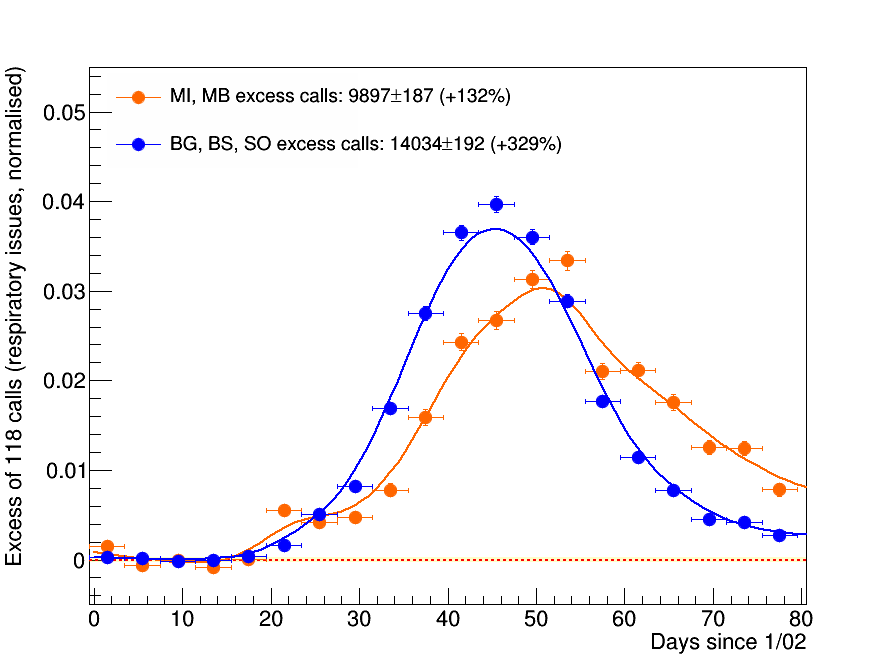

In [17]:
R.gStyle.SetOptTitle(0)
colors=[
    R.kOrange+7,
    R.kBlue
]
labels={
    'milano_brianza':'MI, MB',
    'bergamo_brescia':'BG, BS, SO'
}

leg=R.TLegend(0.12,0.89,0.4,0.75)
leg.SetBorderSize(0)
leg.SetFillColorAlpha(0,0)
leg.SetTextSize(0.03)       

for ip,p in enumerate(dfAREU.columns):
    graphs['chiamateps_%s'%p].Fit('pol0','0+','',0,20)
    graphs['eccesso_chiamateps_%s'%p]=R.TGraphErrors()
    graphs['eccesso_chiamateps_%s'%p]=R.TGraphErrors()
    for i in range(graphs['chiamateps_%s'%p].GetN()):
        x,y=R.Double(0),R.Double(0)
        graphs['chiamateps_%s'%p].GetPoint(i,x,y)
        graphs['eccesso_chiamateps_%s'%p].SetPoint(i,x,y-graphs['chiamateps_%s'%p].GetFunction('pol0').GetParameter(0))
        graphs['eccesso_chiamateps_%s'%p].SetPointError(i,0.5,graphs['chiamateps_%s'%p].GetErrorY(i))
    totalExcess=integralGraph(graphs['eccesso_chiamateps_%s'%p],20)
    normalCalls=graphs['chiamateps_%s'%p].GetFunction('pol0').Integral(20,graphs['eccesso_chiamateps_%s'%p].GetN()-1)
    graphs['eccesso_chiamateps_normalised_%s'%p]=R.TGraphErrors()
    for i in range(graphs['chiamateps_%s'%p].GetN()):
        x,y=R.Double(0),R.Double(0)
        graphs['eccesso_chiamateps_%s'%p].GetPoint(i,x,y)
        graphs['eccesso_chiamateps_normalised_%s'%p].SetPoint(i,x,y/totalExcess[0])
        graphs['eccesso_chiamateps_normalised_%s'%p].SetPointError(i,0.,graphs['eccesso_chiamateps_%s'%p].GetErrorY(i)/totalExcess[0])
        #graphs['eccesso_chiamateps_normalised_%s'%p].SetPoint(i,x,y)
        #graphs['eccesso_chiamateps_normalised_%s'%p].SetPointError(i,0.,graphs['eccesso_chiamateps_%s'%p].GetErrorY(i))
        
    if (ip==0):
        a=R.TH2F('a','a',10,-0.5,80.5,10,-0.005,0.055)
        a.SetStats(0)
        a.GetXaxis().SetTitle("Days since 1/02")
        a.GetYaxis().SetTitle("Excess of 118 calls (respiratory issues, normalised)")
        a.Draw()

        baseline_stdev=graphs['chiamateps_%s'%p].GetFunction('pol0').GetParError(0)/totalExcess[0]
        box=R.TBox(-0.5,-baseline_stdev,80.5,baseline_stdev)
        box.SetFillColorAlpha(R.kYellow,0.20)
    
        line=R.TLine(-0.5,0,80.5,0)
        line.SetLineColor(R.kRed)
        line.SetLineStyle(2)
        line.SetLineWidth(2)
        box.Draw()
        line.Draw()
        
    graphs['eccesso_chiamateps_normalised_%s_rebin4'%p]=rebinGraph(graphs['eccesso_chiamateps_normalised_%s'%p],4,1).Clone('eccesso_chiamateps_normalised_%s_rebin4'%p)
    graphs['eccesso_chiamateps_normalised_%s_rebin4'%p].SetMarkerStyle(20)
    graphs['eccesso_chiamateps_normalised_%s_rebin4'%p].SetMarkerSize(1.5)
    graphs['eccesso_chiamateps_normalised_%s_rebin4'%p].SetMarkerColor(colors[ip])
    graphs['eccesso_chiamateps_normalised_%s_rebin4'%p].SetLineColor(colors[ip])
    graphs['eccesso_chiamateps_normalised_%s_rebin4'%p].Draw('PSAME')
    graphs['eccesso_chiamateps_normalised_%s_smoothed'%p]=smooth1.SmoothKern(graphs['eccesso_chiamateps_normalised_%s'%p],'normal',10).Clone('eccesso_chiamateps_normalised_%s_smoothed'%p)
    graphs['eccesso_chiamateps_normalised_%s_smoothed'%p].SetLineColor(colors[ip])
    graphs['eccesso_chiamateps_normalised_%s_smoothed'%p].SetLineWidth(2)
    #dgompertz.Draw('SAME')
    graphs['eccesso_chiamateps_normalised_%s_smoothed'%p].Draw("LSAME")
    graphs['eccesso_chiamateps_normalised_%s_rebin4'%p].Draw("PSAME")
    leg.AddEntry( graphs['eccesso_chiamateps_normalised_%s_rebin4'%p],
                    '%s excess calls: %.0f#pm%.0f'%(labels[p],totalExcess[0],totalExcess[1]*np.sqrt(2))+' (+{:.0%})'.format(totalExcess[0]/normalCalls)
                    ,'LP')
    
leg.Draw()
c1.Draw()
for ext in ['.pdf','.png','.root']:
    c1.SaveAs("~/cernbox/www/plots/COVID19_DA/AREU_excess"+ext)

In [18]:
smooth=smooth1.SmoothKern(graphs['eccesso_chiamateps_normalised_bergamo_brescia'],'normal',10)

def gFun( x, par ):
    return par[0]*smooth.Eval(x[0])

#truncate lognormal and protect out of bounds
def dieTime( x, par ):
    if (x[0]>0 and x[0]<50):
        return fDieTime.Eval(x[0]-par[0])
    else:
        return 0.

fPS=R.TF1("fPS", gFun, 0, 125, 1)
fPS.SetParameter(0,0.3)
fD=R.TF1("fD", dieTime, 0, 50, 1)
fD.SetParameter(0,0.)

In [20]:
psconv=R.TF1Convolution(fPS,fD,0,125)
fPSConv=R.TF1('fPSConv',psconv,20,80,psconv.GetNpar())
fPSConv.FixParameter(0,478.)
fPSConv.FixParameter(1,0)

<ipython-input-4-45be42f5f186>:89: FutureWarning: ROOT.Double is deprecated and will disappear in a future version of ROOT. Instead, use ctypes.c_double for pass-by-ref of doubles
  g.GetPoint(i,x,y)
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/AREU_excess_Brescia.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/AREU_excess_Brescia.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA/AREU_excess_Brescia.root has been created


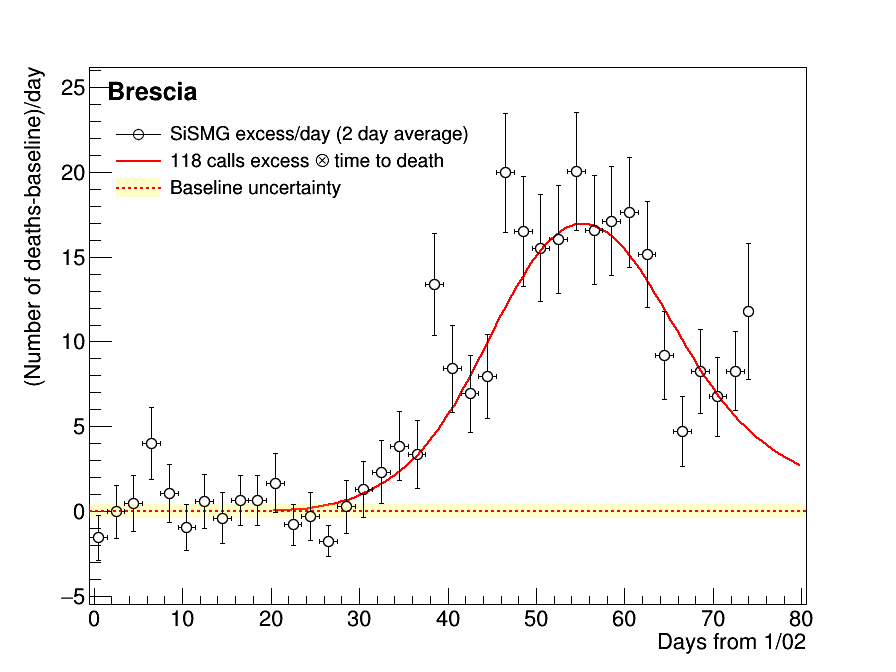

In [21]:
rebin=rebinGraph(graphs['eccesso_deceduti_giornalieri_Brescia'],2,1)
rebin.Draw('AP')
fPSConv.Draw('SAME')
#graphs['eccesso_deceduti_giornalieri_Brescia'].Fit('fPSConv','RB','',20,70)
 
baseline_stdev=graphs['deceduti_giornalieri_Brescia'].GetFunction('fB').GetParError(0)
box=R.TBox(-0.5,-baseline_stdev,80.5,baseline_stdev)
box.SetFillColorAlpha(R.kYellow,0.20)

line=R.TLine(-0.5,0,80.5,0)
line.SetLineColor(R.kRed)
line.SetLineStyle(2)
line.SetLineWidth(2)

rebin.SetMarkerStyle(24)
rebin.SetMarkerSize(1.3)
rebin.GetXaxis().SetLimits(-0.5,80.5)
rebin.GetXaxis().SetRangeUser(-0.5,80.5)
rebin.GetXaxis().SetTitle("Days from 1/02")
rebin.GetYaxis().SetTitle("(Number of deaths-baseline)/day")
box.Draw()
line.Draw()
rebin.Draw('PSAME')
leg=R.TLegend(0.12,0.82,0.4,0.7)
leg.SetBorderSize(0)
leg.SetFillColorAlpha(0,0)
leg.SetTextSize(0.03)   

aux=R.TGraph()
aux.SetFillColorAlpha(R.kYellow,0.2)
aux.SetLineColor(R.kRed)
aux.SetLineWidth(2)
aux.SetLineStyle(2)
leg.AddEntry(rebin,'SiSMG excess/day (2 day average)','PL')
leg.AddEntry(fPSConv,'118 calls excess #otimes time to death','L')
leg.AddEntry(aux,'Baseline uncertainty','FL')
leg.Draw()

t=R.TLatex()
t.SetTextSize(0.04)
t.DrawLatexNDC(0.12,0.85,'%s'%('Brescia'))

c1.Draw()

for ext in ['.pdf','.png','.root']:
    c1.SaveAs("~/cernbox/www/plots/COVID19_DA/AREU_excess_Brescia"+ext)

In [22]:
smooth=smooth1.SmoothKern(graphs['eccesso_chiamateps_normalised_milano_brianza'],'normal',10)

def gFun( x, par ):
    return par[0]*smooth.Eval(x[0])

fPS=R.TF1("fPS", gFun, 0, 125, 1)
fPS.SetParameter(0,0.3)
fD=R.TF1("fD", dieTime, 0, 50, 1)
fD.SetParameter(0,0.)

In [23]:
psconv=R.TF1Convolution(fPS,fD,0,125)
fPSConv=R.TF1('fPSConv',psconv,20,80,psconv.GetNpar())
fPSConv.FixParameter(1,0)
fPSConv.FixParameter(0,2316)

In [ ]:
rebin=rebinGraph(graphs['eccesso_deceduti_giornalieri_Milano'],2,1)
rebin.Draw('AP')
fPSConv.FixParameter(0,2316)
#fPSConv.SetParLimits(0,100,10000)
fPSConv.Draw('SAME')
graphs['eccesso_deceduti_giornalieri_Milano'].Fit('fPSConv','REX0V','',40,70)

baseline_stdev=graphs['deceduti_giornalieri_Milano'].GetFunction('fB').GetParError(0)
box=R.TBox(-0.5,-baseline_stdev,80.5,baseline_stdev)
box.SetFillColorAlpha(R.kYellow,0.20)
    
line=R.TLine(-0.5,0,80.5,0)
line.SetLineColor(R.kRed)
line.SetLineStyle(2)
line.SetLineWidth(2)

rebin.SetMarkerStyle(24)
rebin.SetMarkerSize(1.3)
rebin.GetXaxis().SetLimits(-0.5,80.5)
rebin.GetXaxis().SetRangeUser(-0.5,80.5)
rebin.GetXaxis().SetTitle("Days from 1/02")
rebin.GetYaxis().SetTitle("(Number of deaths-baseline)/day")
box.Draw()
line.Draw()
rebin.Draw('PSAME')
leg=R.TLegend(0.12,0.82,0.4,0.7)
leg.SetBorderSize(0)
leg.SetFillColorAlpha(0,0)
leg.SetTextSize(0.03)   

aux=R.TGraph()
aux.SetFillColorAlpha(R.kYellow,0.2)
aux.SetLineColor(R.kRed)
aux.SetLineWidth(2)
aux.SetLineStyle(2)
leg.AddEntry(rebin,'SiSMG excess/day (2 day average)','PL')
leg.AddEntry(fPSConv,'118 calls excess #otimes time to death','L')
leg.AddEntry(aux,'Baseline uncertainty','FL')
leg.Draw()

t=R.TLatex()
t.SetTextSize(0.04)
t.DrawLatexNDC(0.12,0.85,'%s'%('Milano'))

c1.Draw()

for ext in ['.pdf','.png','.root']:
    c1.SaveAs("~/cernbox/www/plots/COVID19_DA/AREU_excess_Milano"+ext)

In [ ]:
leg=R.TLegend(0.64,0.88,0.89,0.75)
leg.SetBorderSize(0)
leg.SetFillColorAlpha(0,0)
leg.SetTextSize(0.03)       

h1=R.TH1F('dieT','dieT',1000,0,25)
h1.FillRandom('fDieTime',1000000)
xQ=np.zeros(5)
pQ=np.array([0.025,0.1585,0.5,0.8415,0.95])
h1.GetQuantiles(5,xQ,pQ)
print(xQ)

g95=R.TGraphAsymmErrors()
xP=np.linspace(xQ[0],xQ[4],1000)
for i,x in enumerate(xP):
    g95.SetPoint(i,x,0.)
    g95.SetPointError(i,0,0,0,fDieTime.Eval(x))
g95.SetFillColorAlpha(R.kAzure,0.1)
g95.SetLineWidth(0)

g68=R.TGraphAsymmErrors()
xP=np.linspace(xQ[1],xQ[3],1000)
for i,x in enumerate(xP):
    g68.SetPoint(i,x,0.)
    g68.SetPointError(i,0,0,0,fDieTime.Eval(x))
g68.SetFillColorAlpha(R.kAzure,0.4)
g68.SetLineWidth(0)

fDieTime.SetRange(0,25)
fDieTime.Draw('')
fDieTime.GetXaxis().SetTitle('Time death-symptoms (days)')
fDieTime.GetYaxis().SetTitle('Probability')
g95.Draw('3SAME')
g68.Draw('3SAME')
fDieTime.SetLineColor(R.kBlue)
fDieTime.Draw('SAME')

leg.Clear()
leg.AddEntry(fDieTime,'logN(#mu=9.5,#sigma=0.3)','L')
leg.AddEntry(g68,'68.3% interval','F')
leg.AddEntry(g95,'95% interval','F')
leg.Draw()
c1.RedrawAxis()
c1.Draw()

for ext in ['.pdf','.png','.root']:
    c1.SaveAs("~/cernbox/www/plots/COVID19_DA/logNormal"+ext)

In [ ]:
fOut=R.TFile('~/cernbox/www/plots/COVID19_DA/graphsAREU.root','RECREATE')
for o,g in graphs.items():
    g.Write()
fOut.Write()
fOut.Close()